# Downloading Dataset from Mega

## Installing Mega Library

In [ ]:
%%capture
%pip install mega.py
%pip install patool

## Downloading Dataset from Mega Url

In [ ]:
from mega import Mega
import os

# Mega url for the dataset.
data_url = 'https://mega.nz/file/5FhGkRjD#yFihfhr1RMHfPTffhPB4tQtJsnn_HBYFOSfqdPOrp78'
# Dataset folder path.
dataset_folder = 'dataset'
# Create the dataset folder.
os.makedirs(dataset_folder, exist_ok=True)
# Initiate Mega object.
mega = Mega()
# Download file specified in data_url to dataset folder.
dataset_path = mega.download_url(data_url, dataset_folder)

## Extracting Zip File

In [ ]:
import patoolib
import glob

def get_last_file_in_folder(path: str):
  """Get the latest file inserted into a folder."""
  list_of_files = glob.glob(f'{path}/*') # * means all 
  latest_file = max(list_of_files, key=os.path.getctime)
  
  return latest_file


try:
  # Make sure it's an archive. 
  patoolib.get_archive_format(dataset_path)
  # Extract it.
  patoolib.extract_archive(str(dataset_path), outdir= dataset_folder)
  # Make a new location for dataset.
  dataset_path = get_last_file_in_folder(dataset_folder)
  print(f"[INFO] DATASET EXTRACTED AND READY; {dataset_path}")

except Exception as e: 
  dataset_path = str(dataset_path)
  print(f"[INFO] DATASET FOLDER READY; {dataset_path}")

patool: Extracting dataset/pixel-art-pinterest-030.zip ...
patool: running /usr/bin/7z x -odataset -- dataset/pixel-art-pinterest-030.zip
patool: ... dataset/pixel-art-pinterest-030.zip extracted to `dataset'.
[INFO] DATASET EXTRACTED AND READY; dataset/pixel-art-pinterest-030


# CLIP Model and Helper Functions

## CLIP Model Parameters

In [ ]:
# Model type used in generating CLIP feature vectors.
MODEL_TYPE = 'ViT-B-32'
# Pretrained type for the model.
PRETRAINED = 'openai'

## Installing OpenCLIP Library.

In [ ]:
%%capture
%pip install open-clip-torch

In [ ]:
import hashlib
from PIL import Image
import torch
import open_clip

# Creating model, device and preprocess objects for CLIP. 
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_TYPE,pretrained = PRETRAINED)
model = model.to(device)


def compute_sha256(image: Image.Image) -> str: 
    """Compute the SHA256 of a PIL image. """
    return hashlib.sha256(image.tobytes()).hexdigest()


def compute_clip(image: Image.Image):
  """Get normalized clip feature vector for single image."""
  with torch.no_grad():
    image = preprocess(image).unsqueeze(0)
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features
  

def compute_image_bytes(image_path: str):
  file = open(image_path, "rb")
  return file.read()


100%|████████████████████████████████████████| 354M/354M [00:02<00:00, 162MiB/s]


# Manual Ranking Application

## Installing Widget Library

In [ ]:
%%capture
%pip install ipywidgets==7.7.3

## JSON Object Initialization

In [ ]:
JSON_IMAGE_PAIR_LIST = [] # This is the object will be converted into a json file for the dataset.

## Widget Implementation

In [ ]:
import os
import random
import uuid
import json
import datetime
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

class QualityModelWidgets(object):

    def __init__(self) -> None:
        self.step = 0 
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()

    def __get_two_random_images(self):
      global dataset_path
      list_of_images = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) if file_name.endswith(('.png', '.jpeg', '.jpg', 'webp'))]
      return list_of_images[random.randint(0, len(list_of_images))] , list_of_images[random.randint(0, len(list_of_images))]

    def start(self):
        # Initial Images
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()
        # Image widgets
        self.img_widget_1 = widgets.Image(value= compute_image_bytes(self.image_path_1), format='png', width=300, height=400)
        self.img_widget_2 = widgets.Image(value= compute_image_bytes(self.image_path_2), format='png', width=300, height=400)
        # Image labels
        self.lbl_img_1 = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 20px ; font-weight: bold ; color:rgb(75,75,75)">1</p>')
        self.lbl_img_2 = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 20px ; font-weight: bold ; color:rgb(75,75,75)">2</p>')
        self.lbl_img_1.layout.height = '50px'
        self.lbl_img_2.layout.height = '50px'
        
        # Title label
        self.lbl_title_value = f'Quality Model App'
        self.lbl_title = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 24px ; font-weight: bold ; color:rgb(75,75,75)">{self.lbl_title_value}</p>')
        # Tagging User
        self.lbl_user = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75) ; height: 20px">Tagging User: </p>')
        self.txt_user = widgets.Text(value='', disabled=False)
        self.txt_user.layout.width = '250px'
        # Status label
        lbl_status_value = f'Choose Best Image - Iteration: {self.step}'
        self.lbl_status = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75)">{lbl_status_value}</p>')
        self.lbl_status.layout.height = '50px'
        
        # Selection buttons
        self.btn_select_1 = widgets.Button(description = 'SELECT 1', icon='check', button_style = 'success')
        self.btn_select_1.style.button_color = 'rgb(30,144,255)'
        self.btn_select_2 = widgets.Button(description = 'SELECT 2', icon='check', button_style = 'success')
        self.btn_select_2.style.button_color = 'rgb(30,144,255)'
        # Skip button
        self.btn_skip = widgets.Button(description = 'SKIP')
        self.btn_skip.style.button_color = 'rgb(225,225,225)'
        # Layout
        self.box_layout = widgets.Layout(display='flex',
                                    flex_flow='row',
                                    justify_content = 'space-around',
                                    align_items='center',
                                    width='100%'
                                    )
        
        # binding skip button to skip function callback
        self.btn_skip.on_click(self.skip_pressed)
        # binding select button 1 and 2 to select function callback
        self.btn_select_1.on_click(self.select_pressed)
        self.btn_select_2.on_click(self.select_pressed)

        # Show widgets
        self.show_widgets(
                    self.lbl_title,
                    self.lbl_status,
                    self.lbl_user, 
                    self.txt_user, 
                    self.img_widget_1, 
                    self.img_widget_2, 
                    self.lbl_img_1,
                    self.lbl_img_2,
                    self.btn_select_1, 
                    self.btn_select_2, 
                    self.btn_skip, 
                    self.box_layout
                    )


    def get_2_rand_images (self, data_dict):
        # List of hashes (keys in data_dict)
        hash_list = list(data_dict.keys())
        # File 1
        hash_1 = random.choice(hash_list)
        file_path_1 = data_dict[hash_1]['file_path']
        file_name_1 = data_dict[hash_1]['file_name']
        with open(file_path_1, 'rb') as img_file_1:
            img_bytes_1 = img_file_1.read()
        # File 2
        hash_2 = random.choice(hash_list)
        file_path_2 = data_dict[hash_2]['file_path']
        file_name_2 = data_dict[hash_2]['file_name']
        with open(file_path_2, 'rb') as img_file_2:
            img_bytes_2 = img_file_2.read()

        file_dict_1 = {'hash': hash_1, 'file_path': file_path_1, 'file_name': file_name_1, 'img_bytes': img_bytes_1}
        file_dict_2 = {'hash': hash_2, 'file_path': file_path_2, 'file_name': file_name_2, 'img_bytes': img_bytes_2}

        return file_dict_1, file_dict_2


    def show_widgets(self, lbl_title, lbl_status, lbl_user, txt_user, img_1, img_2, lbl_img_1, lbl_img_2, btn_select_1, btn_select_2, btn_skip, box_layout):
        # Header section
        self.box_title = widgets.Box(children=[lbl_title], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'flex-start', align_items='center', width='100%'))
        self.box_user = widgets.Box(children=[lbl_user, txt_user], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'flex-start', align_items='center', width='100%'))
        self.box_status = widgets.Box(children=[lbl_status], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'flex-start', align_items='center', width='100%', height = '100%'))
        
        # Buttons section
        self.box_buttons_select = widgets.Box(children=[btn_select_1, btn_select_2], layout=widgets.Layout(display='flex', flex_flow='column', justify_content = 'space-around', align_items='center', width='100%', height='30%'))
        self.box_buttons_select.layout.margin = '50px 0px 0px 0px'
        self.box_buttons_skip = widgets.Box(children=[btn_skip], layout=widgets.Layout(display='flex', flex_flow='column', justify_content = 'center', align_items='center', width='100%', height='50%'))
        self.box_buttons_container = widgets.Box(children=[self.box_buttons_select, self.box_buttons_skip], layout=widgets.Layout(display='flex', flex_flow='column', align_items='center', width='30%'))
        
        # Image section
        self.box_images = widgets.Box(children=[img_1, img_2], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'space-around', align_items='center', width='100%', height='100%'))
        self.box_lbl_images = widgets.Box(children=[lbl_img_1, lbl_img_2], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'space-around', align_items='center', width='100%', height='10%'))
        self.box_images_container = widgets.Box(children=[self.box_lbl_images, self.box_images], layout=widgets.Layout(display='flex', flex_flow='column', justify_content = 'space-around', align_items='center', width='100%', height='100%'))
        
        # Containing all section
        self.box_buttons_and_images = widgets.Box(children = [self.box_buttons_container, self.box_images_container])

        # Displaying
        display(self.box_title)
        display(self.box_user)
        display(self.box_status)
        display(self.box_buttons_and_images)


    def skip_pressed(self, button):
        # # Currently displayed images
        # self.file_dict_1
        # self.file_dict_2
        # Increment step
        self.step += 1
        clear_output()
        # Update status label
        lbl_status_value = f'Choose Best Image - Iteration: {self.step}'
        self.lbl_status = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75)">{lbl_status_value}</p>')
        # Get new images
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()
        self.img_widget_1 = widgets.Image(value= compute_image_bytes(self.image_path_1), format='png', width=300, height=400)
        self.img_widget_2 = widgets.Image(value= compute_image_bytes(self.image_path_2), format='png', width=300, height=400)

        self.show_widgets(
                    self.lbl_title,
                    self.lbl_status,
                    self.lbl_user, 
                    self.txt_user, 
                    self.img_widget_1, 
                    self.img_widget_2, 
                    self.lbl_img_1,
                    self.lbl_img_2,
                    self.btn_select_1, 
                    self.btn_select_2, 
                    self.btn_skip, 
                    self.box_layout
                    )
        

    def select_pressed(self, button):
        # Increment step
        self.step += 1
        # Time Stamp
        timestamp_str = str(datetime.datetime.now())
        
        '''Which image is selected'''
        if button == self.btn_select_1:
            # Image 1 is selected
            self.save_to_json(image_a_path = self.image_path_1, image_b_path = self.image_path_2)
        elif button == self.btn_select_2:
            # Image 2 is selected
            self.save_to_json(image_a_path = self.image_path_2, image_b_path = self.image_path_1)

        # Clearing widgets
        clear_output()
        # Update status label
        lbl_status_value = f'Choose Best Image - Iteration: {self.step}'
        self.lbl_status = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75)">{lbl_status_value}</p>')
        # Get new images
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()
        self.img_widget_1 = widgets.Image(value= compute_image_bytes(self.image_path_1), format='png', width=300, height=400)
        self.img_widget_2 = widgets.Image(value= compute_image_bytes(self.image_path_2), format='png', width=300, height=400)
        
        self.show_widgets(
                    self.lbl_title,
                    self.lbl_status,
                    self.lbl_user, 
                    self.txt_user, 
                    self.img_widget_1, 
                    self.img_widget_2, 
                    self.lbl_img_1,
                    self.lbl_img_2,
                    self.btn_select_1, 
                    self.btn_select_2, 
                    self.btn_skip, 
                    self.box_layout
                    )


    def save_to_json(self, image_a_path, image_b_path):
        global JSON_IMAGE_PAIR_LIST
        # A dictionary contains a pair of image and it's info.
        pair_dict = {
                      'image_a_path': image_a_path,
                      'image_b_path': image_b_path,
                      'image_a_hash': None,
                      'image_b_hash': None,
                      'image_a_clip': None,
                      'image_b_clip': None
                    }
        # Add the dictionary to the json object.
        JSON_IMAGE_PAIR_LIST.append(pair_dict)



In [ ]:
qualityModelWidgets = QualityModelWidgets()
qualityModelWidgets.start()

Box(children=(HTML(value='<p style="font-family: courier ; font-size: 24px ; font-weight: bold ; color:rgb(75,…

Box(children=(HTML(value='<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,…

Box(children=(HTML(value='<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,…

Box(children=(Box(children=(Box(children=(Button(button_style='success', description='SELECT 1', icon='check',…

In [ ]:
print(f"[INFO] Number of ranked pairs = {len(JSON_IMAGE_PAIR_LIST)}")

[INFO] Number of ranked pairs = 48


## Calculating CLIP/SHA256 and Serializing  

In [ ]:
## Calculating sha256 and CLIP vector for the dataset.
for pair_dict in JSON_IMAGE_PAIR_LIST:
  pair_dict['image_a_hash'] = compute_sha256(Image.open(pair_dict['image_a_path']))
  pair_dict['image_b_hash'] = compute_sha256(Image.open(pair_dict['image_b_path']))
  pair_dict['image_a_clip'] = compute_clip(Image.open(pair_dict['image_a_path'])).detach().numpy().tolist()
  pair_dict['image_b_clip'] = compute_clip(Image.open(pair_dict['image_b_path'])).detach().numpy().tolist()

output_json_path = 'output.json'

# Serialize JSON Object.
json_object = json.dumps(JSON_IMAGE_PAIR_LIST, indent=4)    

# Writing to output folder
with open(output_json_path, "a") as outfile:
  outfile.write(json_object)
  outfile.write('\n')
  outfile.close()

# Ranking Model

## Pytorch Implementation

In [ ]:
import torch
from torch import nn 
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class ImageRankingScoreGenerator(nn.Module):
    def __init__(self, input_dim):
        # Input dimension to the model (CLIP vector dimension)
        self.input_dim = input_dim
        super(ImageRankingScoreGenerator, self).__init__()
        # Single linear layer, from clip vector to a float value.
        self.fc1 = nn.Linear(512, 1) 

    def forward(self, x):
        y = self.fc1(x)
        return y

    def loss(self, v_a, v_b, margin=1):
        """Hinge loss function"""
        # return torch.max(torch.tensor(0), v_a - v_b + margin)
        return torch.max(torch.tensor(0), v_b - v_a + margin)



## Training Loop

In [ ]:
# Number of epochs.
epochs = 50

# Get input_dim from json object.
input_dim = len(JSON_IMAGE_PAIR_LIST[0]["image_a_clip"][0])

# Initiate model object.
my_model = ImageRankingScoreGenerator(input_dim)

# Initialize your optimizer and model
optimizer = optim.SGD(my_model.parameters(), lr=0.001)
for epoch in range(epochs):
  for pair_dict in JSON_IMAGE_PAIR_LIST:
    # Inside your training loop
    optimizer.zero_grad()
    v_a = my_model( torch.tensor(np.array(pair_dict["image_a_clip"]), dtype= torch.float32, requires_grad=True) )
    v_b = my_model( torch.tensor(np.array(pair_dict["image_b_clip"]), dtype= torch.float32, requires_grad=True) )
    print(f"v_a {v_a} , v_b {v_b}")
    loss = my_model.loss(v_a, v_b, margin=1) # Compute the loss
    loss.backward() # Compute gradients
    optimizer.step() # Update model parameters
  print(f"Epoch: {epoch}, Loss: {loss.detach().numpy()[0][0]}")


v_a tensor([[0.0021]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0072]], grad_fn=<AddmmBackward0>)
v_a tensor([[0.0083]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0261]], grad_fn=<AddmmBackward0>)
v_a tensor([[-0.0154]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0023]], grad_fn=<AddmmBackward0>)
v_a tensor([[0.0002]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0080]], grad_fn=<AddmmBackward0>)
v_a tensor([[-0.0065]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0100]], grad_fn=<AddmmBackward0>)
v_a tensor([[0.0204]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0097]], grad_fn=<AddmmBackward0>)
v_a tensor([[-0.0191]], grad_fn=<AddmmBackward0>) , v_b tensor([[-0.0030]], grad_fn=<AddmmBackward0>)
v_a tensor([[-0.0004]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0069]], grad_fn=<AddmmBackward0>)
v_a tensor([[0.0246]], grad_fn=<AddmmBackward0>) , v_b tensor([[0.0408]], grad_fn=<AddmmBackward0>)
v_a tensor([[-0.0154]], grad_fn=<AddmmBackward0>) , v_b tensor([[-0.0185]], grad_fn=<AddmmBackw

## Outputting The Dataset Results.

In [ ]:
# v_a : the value for the chosen image.
# v_b : the value for the NOT chosen image.
# conclusion: lower value is the best rank.
output_values = []
with torch.no_grad():
  for pair_dict in JSON_IMAGE_PAIR_LIST:
    v_a = my_model( torch.tensor(np.array(pair_dict["image_a_clip"]), dtype= torch.float32, requires_grad=False))
    v_b = my_model( torch.tensor(np.array(pair_dict["image_b_clip"]), dtype= torch.float32, requires_grad=False))
    output_values.append(v_a.detach().numpy()[0][0])
    output_values.append(v_b.detach().numpy()[0][0])
    print(f"v_a {v_a.detach().numpy()[0][0]} , v_b {v_b.detach().numpy()[0][0]}")

v_a 0.09353019297122955 , v_b 0.07976841181516647
v_a 0.09312192350625992 , v_b -0.10116203129291534
v_a 0.15541499853134155 , v_b -0.11336319148540497
v_a 0.08853545039892197 , v_b -0.11579972505569458
v_a 0.15760643780231476 , v_b 0.024320503696799278
v_a 0.16069963574409485 , v_b -0.020596997812390327
v_a 0.19894911348819733 , v_b -0.0134629150852561
v_a 0.10271918028593063 , v_b 0.021334221586585045
v_a 0.21745382249355316 , v_b -0.15050022304058075
v_a -0.077764593064785 , v_b 0.17514671385288239
v_a -0.14904992282390594 , v_b -0.1567535102367401
v_a 0.18163354694843292 , v_b -0.19316861033439636
v_a 0.16670849919319153 , v_b -0.0031628634314984083
v_a 0.2101840376853943 , v_b -0.10596908628940582
v_a 0.19867517054080963 , v_b -0.17881418764591217
v_a 0.11677122116088867 , v_b -0.20269955694675446
v_a 0.12867112457752228 , v_b 0.14804944396018982
v_a 0.11619127541780472 , v_b -0.22733786702156067
v_a 0.1280013471841812 , v_b -0.08874951303005219
v_a 0.19670768082141876 , v_b 0.081

## Histogram for Training Set

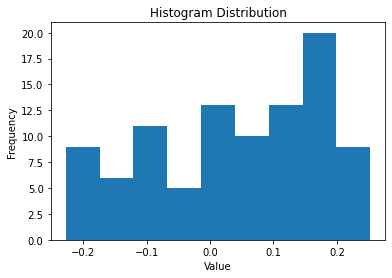

In [ ]:
import matplotlib.pyplot as plt

# create a histogram of the values with 10 bins
plt.hist(output_values, bins= (len(output_values)//10))

# set the title and labels for the histogram
plt.title('Histogram Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show the histogram
plt.show()


## Histogram for All The Dataset.
note: This takes relatively long time, you can skip this.

In [ ]:
import matplotlib.pyplot as plt

folder_output_values = []
for file_name in os.listdir(dataset_path):
  file_path = os.path.join(dataset_path, file_name)
  if os.path.isfile(file_path) and file_path.endswith(('.jpg', '.png', '.jpeg', '.webp')):
    with torch.no_grad():
      v_a = my_model( torch.tensor(np.array(compute_clip(Image.open(file_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
      folder_output_values.append(v_a.detach().numpy()[0][0])


# create a histogram of the values with 10 bins
plt.hist(folder_output_values, bins= (len(folder_output_values)//10))

# set the title and labels for the histogram
plt.title('Histogram Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show the histogram
plt.show()


## Testing The Model On Two Random Images

In [ ]:
random_images_values = []

def get_two_random_images():
  global dataset_path
  list_of_images = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) if file_name.endswith(('.png', '.jpeg', '.jpg', 'webp'))]
  return list_of_images[random.randint(0, len(list_of_images))] , list_of_images[random.randint(0, len(list_of_images))]


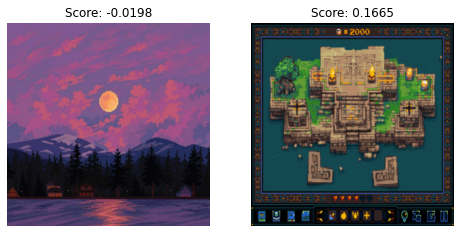

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


first_image_path, second_image_path = get_two_random_images()

with torch.no_grad():
  v_a = my_model( torch.tensor(np.array(compute_clip(Image.open(first_image_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
  v_b = my_model( torch.tensor(np.array(compute_clip(Image.open(second_image_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
  random_images_values.append(v_a.detach().numpy()[0][0])
  random_images_values.append(v_b.detach().numpy()[0][0])
  

# create a figure with two subplots, and set their titles
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.set_title(f'Score: {v_a.detach().numpy()[0][0]:.4f}') 
ax2.set_title(f'Score: {v_b.detach().numpy()[0][0]:.4f}')
ax1.imshow(Image.open(first_image_path).resize((300, 300), resample=Image.BILINEAR))
ax1.axis('off')
ax2.imshow(Image.open(second_image_path).resize((300, 300), resample=Image.BILINEAR))
ax2.axis('off')
plt.show()



## Histogram for Random Images

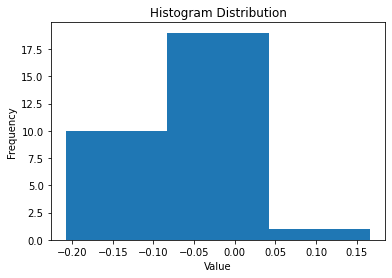

In [ ]:
# create a histogram of the values with 10 bins
plt.hist(random_images_values, bins= (len(random_images_values)//10))

# set the title and labels for the histogram
plt.title('Histogram Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show the histogram
plt.show()

# Ranking Dataset 

## Calculating CLIP and Rank for the Dataset. 

In [ ]:
def convert_gif_to_image(gif_path:str):
    """Delets the GIF and change it to numpy array
    :param gif_path: path to the GIF file.
    :type gif_path: str
    :rtype: np.array
    """
    im = Image.open(gif_path)
    dir_path = os.path.dirname(os.path.abspath(gif_path))
    im.seek(0)
    img_obj = np.array(im)
    im.close()
    return img_obj

def from_numpy_to_pil(np_arr):
  return Image.fromarray(np_arr)

In [ ]:
counter = 0
limit = -1 # this is the limit of number of the images to loop on. 
dataset_length = len(os.listdir(dataset_path))

folder_output_dict = [] # a list of dicts incuding path and rank value.
for file_name in os.listdir(dataset_path):
  try:
    if counter == limit:
      print("[INFO] LIMIT EXCEEDED.")
      break
    file_path = os.path.join(dataset_path, file_name)
    if os.path.isfile(file_path) and file_path.endswith(('.jpg', '.png', '.jpeg', '.webp')):
      with torch.no_grad():
        v_a = my_model( torch.tensor(np.array(compute_clip(Image.open(file_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
        folder_output_dict.append({ 'file_path': file_path, 
                                    'rank': v_a.detach().numpy()[0][0]
                                  })
        
    elif os.path.isfile(file_path) and file_path.endswith(('.gif')):
      with torch.no_grad():
        v_a = my_model(torch.tensor(np.array(compute_clip(from_numpy_to_pil(convert_gif_to_image(file_path))).detach().numpy()), dtype= torch.float32, requires_grad=False))
        folder_output_dict.append({ 'file_path': file_path, 
                                    'rank': v_a.detach().numpy()[0][0]
                                  })
    counter += 1 
    if counter % 100 == 0:
      print(f"[INFO] {counter} IMAGES DONE")

  except Exception as e:
    print(f"[ERROR] {e} IN IMAGE: {file_name}")


# Sorting images based on the rank of them.
sorted_images = sorted(folder_output_dict, key=lambda x: x["rank"], reverse=True)

# Making normalized list of dicts.
normalized_images = []
dec_value = 1 / (len(sorted_images)-1)
for idx, image_dict in enumerate(sorted_images):
  normalized_images.append({
      "file_path": image_dict["file_path"],
      "rank": (1-dec_value*idx)
  })

for image_dict in normalized_images:
  print(image_dict)
  print("-"*40)



Streaming output truncated to the last 5000 lines.
{'file_path': 'dataset/pixel-art-pinterest-030/https___i.pinimg.com_originals_4c_63_27_4c63274383648d85b5cc81d6057b7897.jpg', 'rank': 0.5361510405492385}
----------------------------------------
{'file_path': 'dataset/pixel-art-pinterest-030/https___i.pinimg.com_originals_4b_50_4e_4b504e61202553b141cbf1d660c1bdcb.jpg', 'rank': 0.5359364943145248}
----------------------------------------
{'file_path': 'dataset/pixel-art-pinterest-030/https___i.pinimg.com_originals_49_a9_09_49a909ff144ea1689994bb0ad00b59d7.gif', 'rank': 0.5357219480798112}
----------------------------------------
{'file_path': 'dataset/pixel-art-pinterest-030/https___i.pinimg.com_originals_4e_2d_e0_4e2de0f91bf891a58df20febbf5b5b20.jpg', 'rank': 0.5355074018450976}
----------------------------------------
{'file_path': 'dataset/pixel-art-pinterest-030/https___i.pinimg.com_originals_49_f1_67_49f1676e52ea2b39faf935126220046d.webp', 'rank': 0.535292855610384}
---------------

## Gradio App for Normalized Scores.

In [1]:
%%capture
%pip install -q gradio 

In [34]:
import os
import random
import gradio as gr
import math


def find_images_in_range(min_val, max_val):
  dataset_length = len(normalized_images)

  min_idx = dataset_length -  math.floor(min_val * dataset_length) 
  max_idx = dataset_length - math.ceil(max_val * dataset_length)

  if max_idx < 0:
    max_idx = 0 
  if min_idx >= dataset_length:
    min_idx = dataset_length
  
  images = [
      (
       image_dict["file_path"],
       f'{image_dict["rank"]:.4f}'   
      ) for image_dict in normalized_images[max_idx:min_idx]
  ]

  return images

with gr.Blocks() as demo:
    with gr.Column(variant="panel"):
        with gr.Row(variant="compact"):
            slider1 = gr.Slider(
                label="Select a minimum value",
                show_label=True,
                minimum=0,
                maximum=1,
                step=0.01,
                value=0.5,
            ).style(
                container=False,
            )
            slider2 = gr.Slider(
                label="Select a maximum value",
                show_label=True,
                minimum=0,
                maximum=1,
                step=0.01,
                value=1,
            ).style(
                container=False,
            )
            btn = gr.Button("Find images").style(full_width=False)

        gallery = gr.Gallery(
            label="images", show_label=False, elem_id="gallery"
        ).style(grid=[2], height="auto")

    btn.click(find_images_in_range, [slider1, slider2], gallery)

if __name__ == "__main__":
    demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## Plotting Images After Normalization with Scores.

NOTE: This will draw all the images ( consumes alot of memory.)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Set the number of images per row
images_per_row = 5

# Calculate the number of rows
num_rows = math.ceil(len(normalized_images) / images_per_row)

# Loop through the images and display them in rows
for i in range(num_rows):
    # Create a new row
    row_images = normalized_images[i*images_per_row:(i+1)*images_per_row]
    
    # Create a new figure for the row
    fig = plt.figure(figsize=(20, 20))
    
    # Loop through the images in the row and display them
    for j, image_dict in enumerate(row_images):
        try:
          if image_dict["file_path"].endswith(('.gif')):
            image = convert_gif_to_image(image_dict["file_path"])
        
          # Load the image
          image = mpimg.imread(image_dict["file_path"]) # Returns numpy array of the image.
        
          # Add the image to the figure
          ax = fig.add_subplot(1, images_per_row, j+1)
          ax.set_title(f'Score: {image_dict["rank"]:.4f}')
          ax.imshow(image)
          ax.axis("off")
        except Exception:
          continue
    # Display the row
    plt.show()
